# MODIS Level 2 AOD - AOI Processing, Gridding, and Visualization (Multi-File)

## About

This notebook loads data from multiple MODIS Level 2 (MYD04_L2 or MOD04_L2) NetCDF/HDF files, processes them for a user-defined Area of Interest (AOI), and performs the following:
1. Extracts latitude, longitude, Aerosol Optical Depth at 550nm, and Quality Flags.
2. Converts Scan Start Time to datetime objects.
3. Filters data for the specified AOI and good quality flags (QA=3 for 'Very Good').
4. Visualizes a combined AOD map for the AOI.
5. Saves two ASCII (CSV) files:
    a. All individual good-quality pixel data within the AOI.
    b. Gridded mean AOD values within the AOI.

In [1]:
from pyhdf.SD import SD, SDC 
import numpy as np      
import os                    
import datetime              
import glob                  

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

## Step 2: User Settings, AOI Definition, and File Discovery

In [2]:
# --- User Settings --- #
data_dir_modis = '../data/modis_aod/' # Adjust if your path is different
modis_file_pattern = os.path.join(data_dir_modis, "MYD04_L2*.hdf") # Example for Aqua MODIS
# To include Terra MODIS as well, you might need two patterns or a more general one if naming is consistent
# modis_file_pattern_terra = os.path.join(data_dir_modis, "MOD04_L2*.hdf") 

output_image_dir_modis = '../output/images/' 
output_ascii_dir_modis = '../output/ascii/'

# Define your Area of Interest (AOI)
lat_min_aoi = 7.0   
lat_max_aoi = 23.0
lon_min_aoi = 95.0
lon_max_aoi = 110.0

# Define grid resolution for mean AOD calculation (in degrees)
grid_resolution = 0.5 # e.g., 0.5 means 0.5x0.5 degree grid cells

# Variable names (these are common for MODIS C6/6.1 L2 AOD products)
lat_sds_name = 'Latitude'
lon_sds_name = 'Longitude'
aod_sds_name = 'Optical_Depth_Land_And_Ocean' # Combined Dark Target and Deep Blue AOD
qa_sds_name = 'Land_Ocean_Quality_Flag'      # Quality flag for the combined AOD
time_sds_name = 'Scan_Start_Time'
# --- End User Settings --- #

os.makedirs(output_image_dir_modis, exist_ok=True)
os.makedirs(output_ascii_dir_modis, exist_ok=True)

modis_file_list = sorted(glob.glob(modis_file_pattern))
# modis_file_list.extend(sorted(glob.glob(modis_file_pattern_terra))) # If using Terra too

base_nc_filename_for_output = "MODIS_AOD_Combined" # User-defined base for output filenames

if not modis_file_list:
    print(f"No MODIS HDF files found in {data_dir_modis} matching pattern(s).")
else:
    print(f"Found {len(modis_file_list)} MODIS files to process:")
    for f_name in modis_file_list:
        print(f"- {f_name}")

Found 2 MODIS files to process:
- ../data/modis_aod/MYD04_L2.A2025141.0655.061.2025141192255.hdf
- ../data/modis_aod/MYD04_L2.A2025141.0830.061.2025141192432.hdf


## Step 3: Load Data, Process, Clip to AOI, and Aggregate

In [3]:
# Lists to store data for combined plotting (full granules, AOD filtered and NaNed outside AOI)
latitude_all_granules_plot = []
longitude_all_granules_plot = []
aot550_for_plot_all_granules = []

# Lists for the first ASCII file (all valid pixels within AOI)
ascii_pixels_datetime = []
ascii_pixels_lat = []
ascii_pixels_lon = []
ascii_pixels_aot = []
ascii_pixels_qf = []

# Lists for data to be gridded (valid pixels within AOI)
lat_for_gridding = []
lon_for_gridding = []
aod_for_gridding = []

global_attributes_retrieved = False
aod_long_name_global = "Aerosol Optical Depth at 550nm"
aod_units_global = "1"
any_file_processed_successfully = False

if modis_file_list:
    for file_name in modis_file_list:
        print(f"\n--- Processing file: {os.path.basename(file_name)} ---")
        try:
            hdf = SD(file_name, SDC.READ)
        except Exception as e:
            print(f"  Could not open file {file_name}. Error: {e}")
            continue
        
        try:
            lat_sds = hdf.select(lat_sds_name)
            latitude_current_raw = lat_sds[:,:]
            lon_sds = hdf.select(lon_sds_name)
            longitude_current_raw = lon_sds[:,:]

            aod_sds = hdf.select(aod_sds_name)
            aod_raw = aod_sds[:,:].astype(np.double)
            
            qa_sds = hdf.select(qa_sds_name)
            qa_flag_raw = qa_sds[:,:]
            
            time_sds = hdf.select(time_sds_name)
            scan_start_time_raw = time_sds[:] 

            if not global_attributes_retrieved:
                aod_attributes = aod_sds.attributes(full=1)
                aod_long_name_global = aod_attributes.get("long_name", [aod_sds_name])[0]
                aod_units_global = str(aod_attributes.get("units", ["1"])[0])
                global_attributes_retrieved = True

            # Get fill, scale, offset for AOD for current file
            aod_attrs_curr = aod_sds.attributes(full=1)
            aod_fill_value_curr = aod_attrs_curr.get("_FillValue", [-9999])[0]
            aod_scale_factor_curr = aod_attrs_curr.get("scale_factor", [1.0])[0]
            aod_add_offset_curr = aod_attrs_curr.get("add_offset", [0.0])[0]

            # Get fill value for QA for current file
            qa_attrs_curr = qa_sds.attributes(full=1)
            qa_fill_value_curr = qa_attrs_curr.get("_FillValue", [-9999])[0]

            # Process AOD
            aod_processed_granule = np.where(aod_raw == aod_fill_value_curr, np.nan, aod_raw)
            aod_calibrated_granule = (aod_processed_granule - aod_add_offset_curr) * aod_scale_factor_curr

            # Process QA Flag (use -1 as fill, as QA is often integer)
            qa_flag_processed_granule = np.where(qa_flag_raw == qa_fill_value_curr, -1, qa_flag_raw).astype(np.int8)

            # AOI Mask (using raw lat/lon before fill replacement, assuming fill values are not within typical AOI ranges)
            # MODIS lat/lon fill values are typically large negative numbers, far outside valid geo ranges.
            aoi_mask = (latitude_current_raw >= lat_min_aoi) & (latitude_current_raw <= lat_max_aoi) & \
                         (longitude_current_raw >= lon_min_aoi) & (longitude_current_raw <= lon_max_aoi)

            # Filter AOD by Quality Flag (QA = 3 is usually 'Very Good') and AOI for plotting
            # For data to be plotted, keep original grid, NaN out unwanted pixels
            aot_for_plot_granule = np.where((qa_flag_processed_granule == 3) & aoi_mask, aod_calibrated_granule, np.nan)
            
            latitude_all_granules_plot.append(latitude_current_raw)
            longitude_all_granules_plot.append(longitude_current_raw)
            aot550_for_plot_all_granules.append(aot_for_plot_granule)

            if np.any(~np.isnan(aot_for_plot_granule)):
                any_file_processed_successfully = True

            # Collect valid pixels within AOI for ASCII and gridding
            # Reshape scan_start_time if it's 1D per scanline
            if scan_start_time_raw.ndim == 1 and len(scan_start_time_raw) == latitude_current_raw.shape[0]:
                scan_start_time_pixel_granule = np.repeat(scan_start_time_raw[:, np.newaxis], latitude_current_raw.shape[1], axis=1)
            elif scan_start_time_raw.shape == latitude_current_raw.shape: 
                 scan_start_time_pixel_granule = scan_start_time_raw
            else:
                print(f"  Warning: Scan_Start_Time shape {scan_start_time_raw.shape} not directly compatible with lat shape {latitude_current_raw.shape}.")
                scan_start_time_pixel_granule = np.full_like(latitude_current_raw, np.nan, dtype=float)

            # Extract good quality, AOI-masked pixels
            good_quality_aoi_mask = (qa_flag_processed_granule == 3) & aoi_mask
            
            lats_to_save = latitude_current_raw[good_quality_aoi_mask]
            lons_to_save = longitude_current_raw[good_quality_aoi_mask]
            aod_to_save = aod_calibrated_granule[good_quality_aoi_mask]
            qf_to_save = qa_flag_processed_granule[good_quality_aoi_mask]
            time_to_save = scan_start_time_pixel_granule[good_quality_aoi_mask]
            
            epoch = datetime.datetime(1993, 1, 1, 0, 0, 0, tzinfo=datetime.timezone.utc)
            for idx_save in range(len(lats_to_save)):
                time_val_seconds = time_to_save[idx_save]
                dt_obj = None
                if not np.isnan(time_val_seconds):
                    try:
                        dt_obj = epoch + datetime.timedelta(seconds=float(time_val_seconds))
                    except (ValueError, TypeError):
                        dt_obj = None
                
                if dt_obj is not None:
                    ascii_pixels_datetime.append(dt_obj)
                    ascii_pixels_lat.append(lats_to_save[idx_save])
                    ascii_pixels_lon.append(lons_to_save[idx_save])
                    ascii_pixels_aot.append(aod_to_save[idx_save])
                    ascii_pixels_qf.append(qf_to_save[idx_save])
                    
                    lat_for_gridding.append(lats_to_save[idx_save])
                    lon_for_gridding.append(lons_to_save[idx_save])
                    aod_for_gridding.append(aod_to_save[idx_save])

            print(f"  Data from {os.path.basename(file_name)} processed and relevant pixels collected.")
        
        except Exception as e:
            print(f"  Error processing variables for {os.path.basename(file_name)}: {e}")
        finally:
            hdf.end()
            print(f"  HDF file {os.path.basename(file_name)} has been closed.")

    if not any_file_processed_successfully:
        print("No data was successfully processed from any files.")
    else:
        print(f"\nFinished processing all {len(modis_file_list)} files.")
        # base_nc_filename_for_output remains "MODIS_AOD_Combined" for multi-file case
        # If only one file was in file_list and it was processed, derive name from it
        if len(modis_file_list) == 1 and any_file_processed_successfully:
             base_nc_filename_for_output = f"{os.path.splitext(os.path.basename(modis_file_list[0]))[0]}_AOI"
        elif len(modis_file_list) > 1: # Already set to MODIS_AOD_Combined, add _AOI
            base_nc_filename_for_output = "MODIS_AOD_Combined_AOI"

    print("Data loading and initial processing complete.")
else:
    print("File list is empty. Nothing to process.")


--- Processing file: MYD04_L2.A2025141.0655.061.2025141192255.hdf ---
  Data from MYD04_L2.A2025141.0655.061.2025141192255.hdf processed and relevant pixels collected.
  HDF file MYD04_L2.A2025141.0655.061.2025141192255.hdf has been closed.

--- Processing file: MYD04_L2.A2025141.0830.061.2025141192432.hdf ---
  Data from MYD04_L2.A2025141.0830.061.2025141192432.hdf processed and relevant pixels collected.
  HDF file MYD04_L2.A2025141.0830.061.2025141192432.hdf has been closed.

Finished processing all 2 files.
Data loading and initial processing complete.


## Step 4: Define Map Extent (Based on AOI for Plotting)

In [4]:
map_extent_aoi_plot = None
if any_file_processed_successfully: 
    padding = 2.0 # Degrees to pad the AOI for map display, can be adjusted
    map_extent_aoi_plot = [lon_min_aoi - padding, lon_max_aoi + padding, 
                           lat_min_aoi - padding, lat_max_aoi + padding]
    print(f"Map extent for AOI plotting (with padding): {map_extent_aoi_plot}")
else:
    print("Cannot define map extent as no data was loaded.")

Map extent for AOI plotting (with padding): [93.0, 112.0, 5.0, 25.0]


## Step 5: Visualize and Save Combined & Clipped AOD Map
Aerosol Optical Depth is filtered for QA=3 ('Very Good') and shown for the AOI.

AOI AOD Map saved to: ../output/images/MODIS_AOD_Combined_AOI_AOD550_QA3_AOI.png


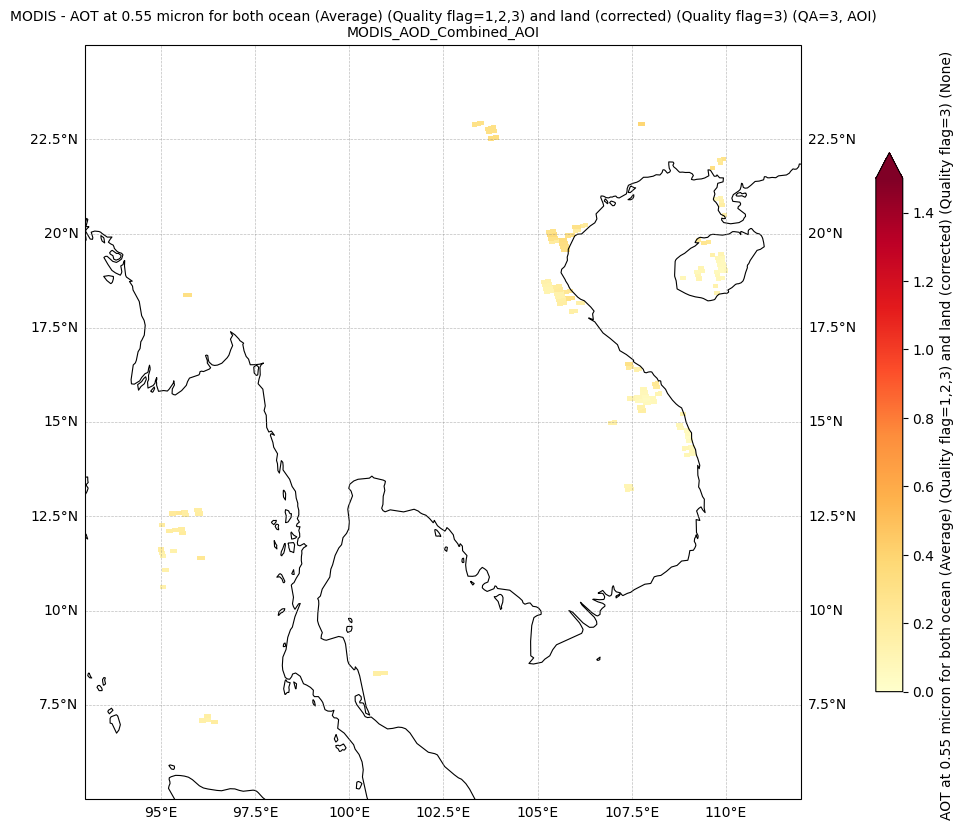

In [5]:
if any_file_processed_successfully and map_extent_aoi_plot is not None and aot550_for_plot_all_granules:
    fig = plt.figure(figsize=(12, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    try:
        ax.set_extent(map_extent_aoi_plot, crs=ccrs.PlateCarree())
    except Exception as e:
        print(f"Error setting map extent {map_extent_aoi_plot}: {e}. Attempting to use broader extent or global.")
        # Fallback for extent calculation if AOI is too small or problematic
        if longitude_all_granules_plot and latitude_all_granules_plot:
            all_lons_flat = np.concatenate([lon.ravel() for lon in longitude_all_granules_plot if lon.size > 0 and np.any(~np.isnan(lon))])
            all_lats_flat = np.concatenate([lat.ravel() for lat in latitude_all_granules_plot if lat.size > 0 and np.any(~np.isnan(lat))])
            if all_lons_flat.size > 0 and all_lats_flat.size > 0:
                ax.set_extent([np.nanmin(all_lons_flat)-1, np.nanmax(all_lons_flat)+1, np.nanmin(all_lats_flat)-1, np.nanmax(all_lats_flat)+1], crs=ccrs.PlateCarree())
            else:
                ax.set_global()
        else:
             ax.set_global()
    
    ax.coastlines(resolution='50m', color='black', linewidth=0.8)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = True 
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    plotted_mesh_aod = None 
    
    for i in range(len(longitude_all_granules_plot)):
        lon_granule = longitude_all_granules_plot[i]
        lat_granule = latitude_all_granules_plot[i]
        aod_to_plot = aot550_for_plot_all_granules[i]

        if aod_to_plot.size > 0 and np.any(~np.isnan(aod_to_plot)):
            # For pcolormesh, data should be 2D. If already filtered, NaNs will make them not appear.
            mesh = ax.pcolormesh(lon_granule, lat_granule, aod_to_plot, 
                                 transform=ccrs.PlateCarree(), 
                                 cmap='YlOrRd', 
                                 vmin=0, 
                                 vmax=1.5, # MODIS AOD can go higher
                                 shading='auto')
            if plotted_mesh_aod is None: 
                plotted_mesh_aod = mesh
    
    title_str_prefix = f'MODIS - {aod_long_name_global} (QA=3, AOI)'
    title_str_suffix = base_nc_filename_for_output

    if plotted_mesh_aod is not None:
        cbar = plt.colorbar(plotted_mesh_aod, ax=ax, orientation='vertical', pad=0.08, shrink=0.7, extend='max')
        cbar.set_label(f"{aod_long_name_global} ({aod_units_global})")
        plt.title(f'{title_str_prefix}\n{title_str_suffix}', fontsize=10)
    else:
        print("No valid AOD data within AOI to plot across all granules.")
        plt.title(f'{title_str_prefix}\nNo valid data in AOI from loaded files', fontsize=10)
    
    save_filename_aod = f"{base_nc_filename_for_output}_AOD550_QA3_AOI.png"
    full_save_path_aod = os.path.join(output_image_dir_modis, save_filename_aod)
    plt.savefig(full_save_path_aod, dpi=300, bbox_inches='tight') 
    print(f"AOI AOD Map saved to: {full_save_path_aod}")
    plt.show() 
    plt.close(fig)
else:
    print("Skipping AOD map plotting: No plottable data or map extent problem.")

## Step 6: Create Gridded Mean AOD for AOI

In [6]:
gridded_mean_aod_for_ascii = [] 

if any_file_processed_successfully and lat_for_gridding and map_extent_aoi_plot is not None:
    print(f"\nCalculating gridded mean AOD for AOI with {grid_resolution}-degree resolution...")
    
    np_lat_for_gridding = np.array(lat_for_gridding)
    np_lon_for_gridding = np.array(lon_for_gridding)
    np_aod_for_gridding = np.array(aod_for_gridding)

    epsilon = 1e-6 
    lon_bins = np.arange(lon_min_aoi, lon_max_aoi + grid_resolution + epsilon, grid_resolution)
    lat_bins = np.arange(lat_min_aoi, lat_max_aoi + grid_resolution + epsilon, grid_resolution)
    
    if len(lon_bins) < 2 or len(lat_bins) < 2:
        print("Warning: Grid resolution too large for AOI, or AOI is too small. Cannot create grid.")
    elif np_lat_for_gridding.size == 0:
        print("No data points available for gridding within AOI and QA criteria.")
    else:
        aod_sum_in_bins, _, _ = np.histogram2d(
            np_lat_for_gridding, 
            np_lon_for_gridding, 
            bins=[lat_bins, lon_bins],
            weights=np_aod_for_gridding 
        )
        
        points_in_bins, _, _ = np.histogram2d(
            np_lat_for_gridding, 
            np_lon_for_gridding, 
            bins=[lat_bins, lon_bins]
        )
        
        mean_aod_in_bins = np.full_like(aod_sum_in_bins, np.nan)
        valid_bins_mask = points_in_bins > 0
        mean_aod_in_bins[valid_bins_mask] = aod_sum_in_bins[valid_bins_mask] / points_in_bins[valid_bins_mask]
        
        lon_bin_centers = (lon_bins[:-1] + lon_bins[1:]) / 2
        lat_bin_centers = (lat_bins[:-1] + lat_bins[1:]) / 2
        
        for i_lat, lat_center in enumerate(lat_bin_centers):
            for i_lon, lon_center in enumerate(lon_bin_centers):
                mean_aod_val = mean_aod_in_bins[i_lat, i_lon] 
                if not np.isnan(mean_aod_val):
                    gridded_mean_aod_for_ascii.append((lat_center, lon_center, mean_aod_val))
        
        print(f"Calculated gridded mean AOD for {len(gridded_mean_aod_for_ascii)} grid cells.")
else:
    print("Skipping gridded mean AOD calculation: No data available for gridding or AOI not defined.")


Calculating gridded mean AOD for AOI with 0.5-degree resolution...
Calculated gridded mean AOD for 50 grid cells.


## Step 7: Save Extracted Data to ASCII (CSV) Files

In [7]:
# Save ASCII File 1: All valid pixels within AOI
if any_file_processed_successfully and ascii_pixels_datetime:
    ascii_pixels_filename = f"{base_nc_filename_for_output}_AOI_pixels.csv"
    full_ascii_pixels_path = os.path.join(output_ascii_dir_modis, ascii_pixels_filename)

    print(f"\nSaving all valid AOI pixel data to: {full_ascii_pixels_path}")
    with open(full_ascii_pixels_path, 'w') as f:
        f.write("Datetime,Latitude,Longitude,AOD_550_QF3,QualityFlag\n") # Header reflects QA=3
        for i in range(len(ascii_pixels_datetime)):
            dt_obj = ascii_pixels_datetime[i]
            lat_val = ascii_pixels_lat[i]
            lon_val = ascii_pixels_lon[i]
            aot_val = ascii_pixels_aot[i]
            qf_val = ascii_pixels_qf[i]
            
            dt_str = dt_obj.strftime('%Y-%m-%dT%H:%M:%S.%fZ') 
            f.write(f"{dt_str},{lat_val:.4f},{lon_val:.4f},{aot_val:.4f},{int(qf_val)}\n")
        print(f"Finished writing AOI pixel data. {len(ascii_pixels_datetime)} points written.")
else:
    print("Skipping ASCII file for AOI pixels: No valid data points were processed for output.")

# Save ASCII File 2: Gridded mean AOD within AOI
if any_file_processed_successfully and gridded_mean_aod_for_ascii:
    ascii_gridded_filename = f"{base_nc_filename_for_output}_AOI_gridded_mean_{grid_resolution}deg.csv"
    full_ascii_gridded_path = os.path.join(output_ascii_dir_modis, ascii_gridded_filename)

    print(f"\nSaving gridded mean AOD data to: {full_ascii_gridded_path}")
    with open(full_ascii_gridded_path, 'w') as f:
        f.write("Latitude_center,Longitude_center,Mean_AOT550_QF3\n") # Header reflects QA=3
        for lat_center, lon_center, mean_aod_val in gridded_mean_aod_for_ascii:
            f.write(f"{lat_center:.4f},{lon_center:.4f},{mean_aod_val:.4f}\n")
        print(f"Finished writing gridded mean AOD data. {len(gridded_mean_aod_for_ascii)} grid cells written.")
else:
    print("Skipping ASCII file for gridded mean AOT: No data was available for gridding.")


Saving all valid AOI pixel data to: ../output/ascii/MODIS_AOD_Combined_AOI_AOI_pixels.csv
Finished writing AOI pixel data. 124 points written.

Saving gridded mean AOD data to: ../output/ascii/MODIS_AOD_Combined_AOI_AOI_gridded_mean_0.5deg.csv
Finished writing gridded mean AOD data. 50 grid cells written.


## End of Processing

In [8]:
print("MODIS Data Processing Complete.")

MODIS Data Processing Complete.
